In [217]:
import sys
sys.path.append('../_amigocloud')

from werkzeug.wrappers import Request, Response
from jinja2 import Template
from datetime import datetime, timedelta
import collections
from datetime import datetime

from shapely import wkb
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import requests

from amigocloud import AmigoCloud

import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [115]:
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

## conversion de poligono

In [218]:
def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)

## conrvertir formato fecha

In [176]:
# convierte de formato YYYY-mm-dd H:M:S+z a d/m/YYYY
def convertir_formato_fecha(fecha):
    new_formato = datetime.strptime(fecha, "%Y-%m-%d %H:%M:%S%z").strftime("%d/%m/%Y")
    return new_formato

## ejecutar query

In [139]:
# ejecuta cualquier query sql en el proyecto que se le indique
# requiere el id de proyecto, query a ejecutar y tipo solicitud (get o post)
def ejecutar_query_sql(id_project, query, tipo_sql):
    # define la url del proyecto para ejecutar el querry
    url_proyecto_sql = f'https://app.amigocloud.com/api/v1/projects/{id_project}/sql'
    # crea la estructura de query para amigocloud
    query_sql = {'query': query}
    # variable para almacenar resultado
    resultado_get = ''
    # eleige que tipo de solicitud se realizara (get o post)
    if tipo_sql == 'get': 
        resultado_get = amigocloud.get(url_proyecto_sql, query_sql)
    elif tipo_sql == 'post':
        resultado_get = amigocloud.post(url_proyecto_sql, query_sql)
    else:
        resultado_get = 'Se a seleccionado un tipo de solicitud erroneo.'
    return resultado_get

## ejecuta query segun id_query (ejecucion de queryes de un proyecto)

In [140]:
# ejecuta un query que esta almacenado en un proyecto de amigocloud (generalmente un update),
# requiere id de proyecto e id de query
# retorna cuantas filas fueron afectadas
def ejecutar_query_por_id(id_project, id_query, tipo_sql):
    # obtiene el query basado en el id_project y el id_query
    get_query = amigocloud.get(f'https://app.amigocloud.com/api/v1/projects/{id_project}/queries/{id_query}')
    # se extrae solo el texto del query
    query = get_query['query']
    # ejecuta el query_sql con metodo post y guarda la respuesta
    respuesta_post = ejecutar_query_sql(id_project, query, tipo_sql)
    # retorna el numero de filas afectadas por el query
    return respuesta_post

## convertir dic en obj

In [141]:
# convierte un dict a un obj
# recibe el dict y el nombre con el que se creara el obj
def convertir_dict_obj(diccionario, name):
    return collections.namedtuple(name, diccionario.keys())(*diccionario.values())

## crear CITE

In [183]:
def crear_cite(cod_canhero, nom_canhero, tipo_reporte):
    ruta_api_google = ruta + '\_keys\client_secret_google_sheets.json'
    # Configura las credenciales
    scope = ["https://spreadsheets.google.com/feeds",
             'https://www.googleapis.com/auth/spreadsheets', 
             "https://www.googleapis.com/auth/drive.file", 
             "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(ruta_api_google, scope)
    client = gspread.authorize(creds)
    # Abre la hoja de cálculo con ID y la hoja específica
    spreadsheet = client.open_by_key("1JROdo_Mjx6267cDfFvTFvhk1aE2_XTc28PfTgRxfwNQ")
    sheet = spreadsheet.sheet1
    # Lee los datos
    data_sheet = sheet.get_all_records()
    df = pd.DataFrame(data_sheet)
    # Encuentra el número más grande y lo incrementamos y agrega un nuevo registro
    max_value = df['No'].max()
    no = int(max_value + 1)
    # llenamos los demas campos
    fecha = datetime.now().strftime("%m/%d/%Y")
    cod_ca = int(cod_canhero)
    nom_ca = nom_canhero
    tipo = tipo_reporte
    #agregar el registro
    sheet.append_row([no, fecha, cod_ca, nom_ca, tipo])
    return no

In [142]:
# variables globales
proyecto_id = 31874

buscar_reg_nuevos = 6476
cargar_lotes_quema = 6474
calc_area_lotes = 5078
calc_total_insp = 6475

In [143]:
# revisa y extiste registros nuevos (campo reporte_generado en false)
rec_nuevos = ejecutar_query_por_id(proyecto_id, buscar_reg_nuevos, 'get')
# se queda con la parte de darta
rec_nuevos = rec_nuevos['data']
# extrae el id de los nuevos regitros
id_nuevos = [i['id'] for i in rec_nuevos]

In [219]:
# ejecuatar scripts generales para completar campos y recalculos
exe_cargar_lotes_quema = ejecutar_query_por_id(proyecto_id, cargar_lotes_quema, 'post')
exe_calc_area_lotes = ejecutar_query_por_id(proyecto_id, calc_area_lotes, 'post')
exe_calc_total_insp = ejecutar_query_por_id(proyecto_id, calc_total_insp, 'post')

In [200]:
id = 189

In [201]:
# seleccionar un registro
# crear consulta
query = f'select * from dataset_351059 where id = {id}'
# ejecutar consulta
inspeccion = ejecutar_query_sql(proyecto_id, query, 'get')
# extrae la seccion de data
inspeccion = inspeccion['data']
# extrae el primer elemento, solo hay un elemento
inspeccion = inspeccion[0]
# convertion de formato de fechas
inspeccion['date'] = convertir_formato_fecha(inspeccion['fecha_registro'])
inspeccion['fecha_inspeccion'] = convertir_formato_fecha(inspeccion['fecha_inspeccion'])
inspeccion['fecha_quema'] = convertir_formato_fecha(inspeccion['fecha_quema'])
# extraccion de codigo y nombre del cañero
cod_ca = inspeccion['canhero'].split(' / ')[0]
nom_ca = inspeccion['canhero'].split(' / ')[1]
# crear y asignar cite
cite = crear_cite(cod_ca, nom_ca, 'QUEMA')
inspeccion['cite'] = cite
# convertir el dict en objeto
insp = convertir_dict_obj(inspeccion, 'insp')

In [202]:
insp

insp(id=189, informe_generado=False, fecha_registro='2024-08-06 12:06:43+00:00', fecha_quema='05/08/2024', fecha_inspeccion='06/08/2024', canhero='75 / AGUILERA TARADELLES MARIANO', superficie_total=9.97, rendimiento=60.0, produccion=598.2, cite=274, inicio_incendio='Dentro de la propiedad', causa='Quema de malojo', responsable_de_quema='Propio', observaciones='Sin obs', link_informe=None, tipo_cosecha='MECANIZADO', amigo_id='069ec93bf7544b129a16511331c4ab65', responsable_tec='Bismark Socompi Rodríguez', ubicacion='0104000020E610000002000000010100000095B0805369A34FC0807D1931585231C0010100000077B5DC9909A34FC0EF01BA2F675231C0', date='06/08/2024')

In [203]:
# seleccionar todos los lotes marcados con la inspeccion
# crear consulta
query = f'select * from dataset_351061 where id_inspeccion = {id}'
# ejecutar consulta
lotes = ejecutar_query_sql(proyecto_id, query, 'get')
# extraer solo la seccion de data
lotes = lotes['data']

In [204]:
lotes

[{'fecha_registro': '2024-08-06 13:15:19.416607+00:00',
  'amigo_id': '2683208b81ce49d7b8f361e82fa158fd',
  'id': 9,
  'geometria': '0106000020E61000000100000001030000000100000008000000315B2067D2A24FC082AB3055715231C0B64B466A08A34FC0B137553E9C5231C0BB6A8E0A08A34FC06C3D1145D05231C03248A75329A34FC09CB74BEEEB5231C014AAA95B3AA34FC059D743C5455231C0FB2772D7E3A24FC04F3CC2AA205231C0A732A152E2A24FC097DA9B22205231C0315B2067D2A24FC082AB3055715231C0',
  'unidad_05': 'L3',
  'unidad_01': '1624',
  'unidad_02': 'COFADENA',
  'area': 6.33,
  'id_inspeccion': 189},
 {'fecha_registro': '2024-08-06 13:15:19.416607+00:00',
  'amigo_id': 'be2c3ded0c9a49db80a5e0af259d2b9d',
  'id': 10,
  'geometria': '0106000020E6100000010000000103000000010000000A000000A2EF6E6589A34FC088DA368C825231C0643BDF4F8DA34FC0AD65D7625C5231C03201BF4692A34FC0FAA2F3D02D5231C049F59D5F94A34FC0EF247DB5FE5131C02705CC327AA34FC07898F6CDFD5131C05354A29174A34FC08347C08D395231C0FE28EACC3DA34FC0AE2589CA2B5231C006B0123D3AA34FC0C44549A35D5231C0D5

In [205]:
# elimina todos los dic duplicados basandose en "unidad_01", y concerva solo en cop_prop y nom_prop
# con esto se obtiene un dict de propiedades de la inspeccion
def eliminar_duplicados_y_conservar_campos(lista, campo_clave, campos_a_conservar):
    vistos = set()
    nueva_lista = []
    for diccionario in lista:
        valor = diccionario[campo_clave]
        if valor not in vistos:
            vistos.add(valor)
            nuevo_diccionario = {campo: diccionario[campo] for campo in campos_a_conservar}
            nueva_lista.append(nuevo_diccionario)
    return nueva_lista

In [206]:
# de lotes eliminar todos los duplicados, y solo se queda con el codigo y nombre de propiedad, esto sera el objeto de propiedades que son parte de la inspeccion
props = eliminar_duplicados_y_conservar_campos(lotes, 'unidad_01', ['unidad_01', 'unidad_02'])

In [207]:
props

[{'unidad_01': '1624', 'unidad_02': 'COFADENA'}]

In [208]:
# recorrer las propiedades, y agregar los lotes correspondientes
# se crea una lista de objetos propiedad con los respectivos lotes agregados a cada propiedad
propiedades = []
for prop in props:
    prop['lote'] = []
    lotes_select = [lote for lote in lotes if lote['unidad_01'] == prop['unidad_01']]
    for lote_select in lotes_select:
        lote = convertir_dict_obj(lote_select, 'lote')
        prop['lote'].append(lote)
    propiedades.append(convertir_dict_obj(prop, 'propiedad'))
print('end')

end


In [209]:
propiedades

[propiedad(unidad_01='1624', unidad_02='COFADENA', lote=[lote(fecha_registro='2024-08-06 13:15:19.416607+00:00', amigo_id='2683208b81ce49d7b8f361e82fa158fd', id=9, geometria='0106000020E61000000100000001030000000100000008000000315B2067D2A24FC082AB3055715231C0B64B466A08A34FC0B137553E9C5231C0BB6A8E0A08A34FC06C3D1145D05231C03248A75329A34FC09CB74BEEEB5231C014AAA95B3AA34FC059D743C5455231C0FB2772D7E3A24FC04F3CC2AA205231C0A732A152E2A24FC097DA9B22205231C0315B2067D2A24FC082AB3055715231C0', unidad_05='L3', unidad_01='1624', unidad_02='COFADENA', area=6.33, id_inspeccion=189), lote(fecha_registro='2024-08-06 13:15:19.416607+00:00', amigo_id='be2c3ded0c9a49db80a5e0af259d2b9d', id=10, geometria='0106000020E6100000010000000103000000010000000A000000A2EF6E6589A34FC088DA368C825231C0643BDF4F8DA34FC0AD65D7625C5231C03201BF4692A34FC0FAA2F3D02D5231C049F59D5F94A34FC0EF247DB5FE5131C02705CC327AA34FC07898F6CDFD5131C05354A29174A34FC08347C08D395231C0FE28EACC3DA34FC0AE2589CA2B5231C006B0123D3AA34FC0C44549A35D5231C0

In [210]:
# buscar todas las fotos que son parte de la inspeccion
# crear consulta
query = f'select s3_filename from gallery_61142 where source_amigo_id = \'{insp.amigo_id}\''
# ejecutar consulta
fotos = ejecutar_query_sql(proyecto_id, query, 'get')
# extrae la seccion de data
fotos = fotos['data']

In [211]:
fotos

[{'s3_filename': 'IMG-20240805-WA0051_Us9M6Ok.jpg'},
 {'s3_filename': '61142_20240806181903744.jpg'}]

C:\Documents\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON/planos/069ec93bf7544b129a16511331c4ab65_1624.jpeg


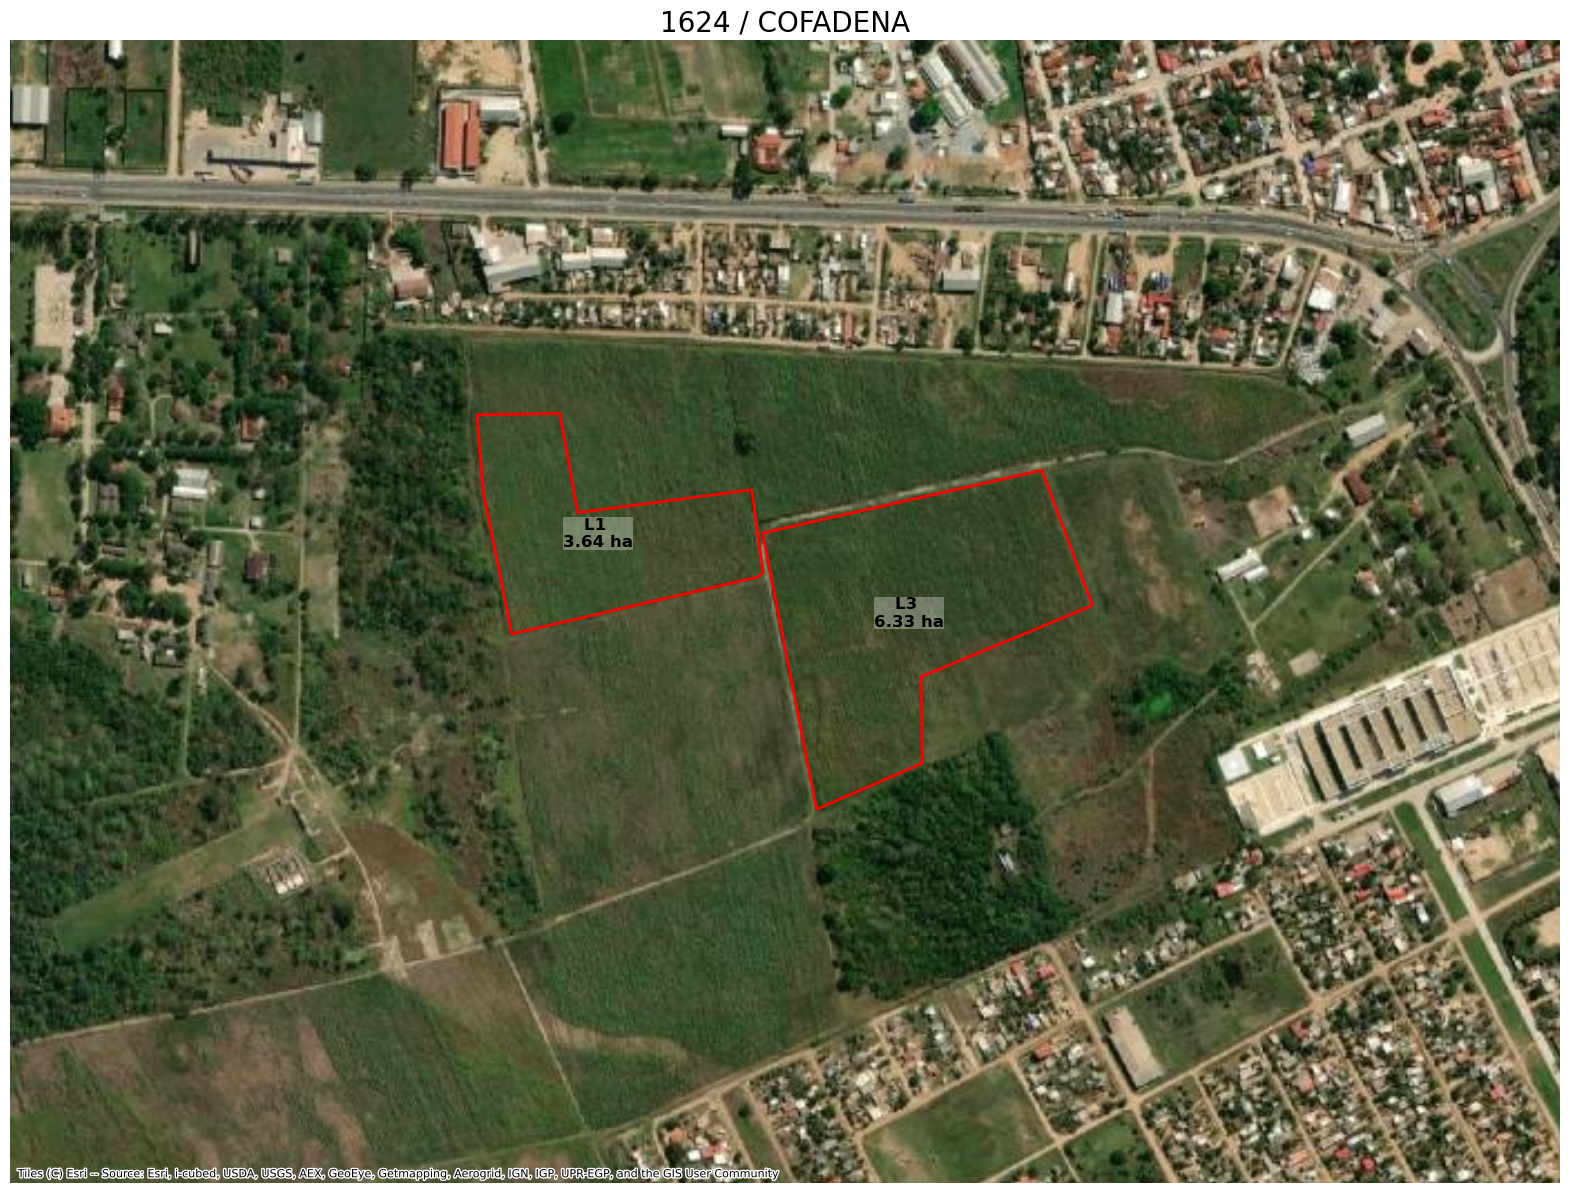

In [220]:
# generar planos
i = 0
lista_planos = []
path = ''
for propiedad in propiedades:
    i = i + 1
    lotes_lista = []
    for lote in propiedad.lote:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = gpd.GeoDataFrame(df, geometry='geometria')

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)

    
    fig = plt.figure(i, figsize=(20,20))
    ax = None
    ax = fig.add_subplot()

    data.apply(lambda x: ax.annotate(text=x.unidad_05 + ' \n' + str(x.area) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);
    
    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    ax.set_axis_off()
    ax.set_title(str(propiedad.unidad_01) + ' / ' + str(propiedad.unidad_02), fontsize=20)
    path = ruta + '/planos/' + str(insp.amigo_id) + '_' + str(propiedad.unidad_01) + '.jpeg'
    lista_planos.append(path)
    fig.savefig(path, dpi = 300, bbox_inches='tight')
    del fig
print(path)

In [214]:
# generar reporte
# asignacion de template
doc = DocxTemplate(ruta + "/templates/tpl_infome_quema.docx")

#generar lista de InlineImage de planos 
lista_InlineImage = []
for plano in lista_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

#descargar fotos y generar lista InlineImage
lista_fotos_inline = []
for foto in fotos:
    response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['s3_filename'])
    file = open(ruta + '/fotos/' + foto['s3_filename'], "wb")
    file.write(response.content)
    file.close()
    lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor= ruta + '/fotos/' + foto['s3_filename'], width=Mm(120))})

firma_respon = None
if insp.responsable_tec == 'Rogelio Acuña Rodríguez':
    firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_rogelio.png', width=Mm(60))
else:
    firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_jaldin.png', width=Mm(60))

context = {'insp':insp, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}

doc.render(context)

# formato de nombre de archivo: "123_CQ_01-01-2022_NOMBRE"
cod_nom = insp.canhero.split(' / ')
file_name = cod_nom[0] + '_CAQU_' + insp.fecha_inspeccion.replace('/','-') + '_' + cod_nom[1] + '_' + str(insp.id)

doc.save(ruta + '/informes/_' + file_name + '.docx')

In [215]:
# actualizar estado de informe_generado a true
# crear consulta
query = f'update dataset_351059 set informe_generado = true where id = {id}'
# ejecutar consulta
res = ejecutar_query_sql(proyecto_id, query, 'post')
res

{'query': 'update dataset_351059 set informe_generado = true where id = 189',
 'count': 1,
 'amigo_ids': ['069ec93bf7544b129a16511331c4ab65']}